## Imports

In [1]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import joblib

## Dataset

In [2]:
weather = pd.read_csv("weather_data_35_years.csv", index_col="time")

In [3]:
weather.index = pd.to_datetime(weather.index)

In [4]:
weather.head()

,temperature_2m_max (°C),temperature_2m_min (°C),weather_code (wmo code),wind_speed_10m_max (km/h),cloud_cover_mean (%),relative_humidity_2m_mean (%),pressure_msl_mean (hPa),cloud_cover_max (%),dew_point_2m_mean (°C),temperature_2m_mean (°C),apparent_temperature_mean (°C),wind_speed_10m_mean (km/h),precipitation_sum (mm)
time,,,,,,,,,,,,,
1990-01-01,26.6,23.5,51,17.2,65,84,1012.2,100,21.8,24.7,27.9,11.3,1.3
1990-01-02,27.1,22.4,51,17.4,35,79,1012.7,67,20.5,24.5,26.9,12.5,0.1
1990-01-03,27.4,22.5,51,19.2,47,76,1013.9,84,20.0,24.7,26.4,14.6,0.1
1990-01-04,26.9,23.1,3,23.7,63,76,1015.2,100,20.0,24.6,25.9,18.0,0.0
1990-01-05,26.8,22.2,3,29.8,72,71,1015.5,99,18.7,24.5,24.5,22.1,0.0


C:\Users\TC Admin\AppData\Local\Temp\ipykernel_18756\1904441351.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='weather_encoded', data=weather, palette='hls')


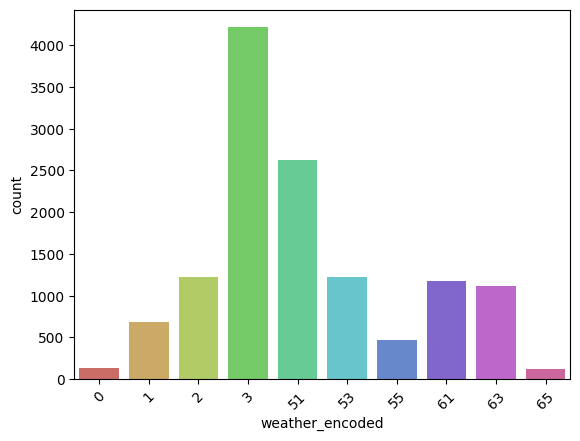

In [5]:
# Create a label encoder object
le = LabelEncoder()

# Fit the encoder to the weather column and transform the values
weather['weather_encoded'] = le.fit_transform(weather['weather_code (wmo code)'])

# Plot counts
ax = sns.countplot(x='weather_encoded', data=weather, palette='hls')

weather_names = dict(zip(le.classes_, le.transform(le.classes_)))
# Replace tick labels with actual names
ax.set_xticks(range(len(weather_names)))
ax.set_xticklabels(list(weather_names.keys()), rotation=45)

plt.show()


In [6]:
weather[["temperature_2m_max (°C)","temperature_2m_min (°C)",'wind_speed_10m_max (km/h)','precipitation_sum (mm)','temperature_2m_mean (°C)',
        'dew_point_2m_mean (°C)','cloud_cover_max (%)','relative_humidity_2m_mean (%)','pressure_msl_mean (hPa)', 'cloud_cover_mean (%)',
        'apparent_temperature_mean (°C)']].describe()

,temperature_2m_max (°C),temperature_2m_min (°C),wind_speed_10m_max (km/h),precipitation_sum (mm),temperature_2m_mean (°C),dew_point_2m_mean (°C),cloud_cover_max (%),relative_humidity_2m_mean (%),pressure_msl_mean (hPa),cloud_cover_mean (%),apparent_temperature_mean (°C)
count,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000
mean,31.828837,24.904527,18.356756,2.867646,27.889758,22.182369,88.493753,73.046738,1008.735524,61.960589,31.332855
std,3.325902,2.650919,4.233653,8.671642,2.592145,2.118883,20.141438,9.165689,3.833016,30.953615,3.303684
min,22.900000,15.200000,6.900000,0.000000,21.100000,14.600000,0.000000,36.000000,995.400000,0.000000,20.800000
25%,28.900000,23.200000,15.500000,0.000000,25.700000,20.800000,86.000000,68.000000,1005.600000,34.000000,28.700000
50%,32.000000,25.200000,18.200000,0.100000,28.100000,22.600000,100.000000,74.000000,1008.500000,66.000000,32.100000
75%,34.300000,26.900000,21.000000,1.900000,29.900000,23.800000,100.000000,79.000000,1011.900000,93.000000,33.875000
max,41.900000,31.600000,65.200000,255.800000,35.600000,27.200000,100.000000,94.000000,1018.400000,100.000000,39.100000


In [7]:
variables = ['temperature_2m_max (°C)',
 'temperature_2m_min (°C)',
 'wind_speed_10m_max (km/h)',
 'cloud_cover_mean (%)',
 'relative_humidity_2m_mean (%)',
 'pressure_msl_mean (hPa)',
 'cloud_cover_max (%)',
 'dew_point_2m_mean (°C)',
 'temperature_2m_mean (°C)',
 'apparent_temperature_mean (°C)',
 'wind_speed_10m_mean (km/h)',
 'precipitation_sum (mm)','weather_code (wmo code)']

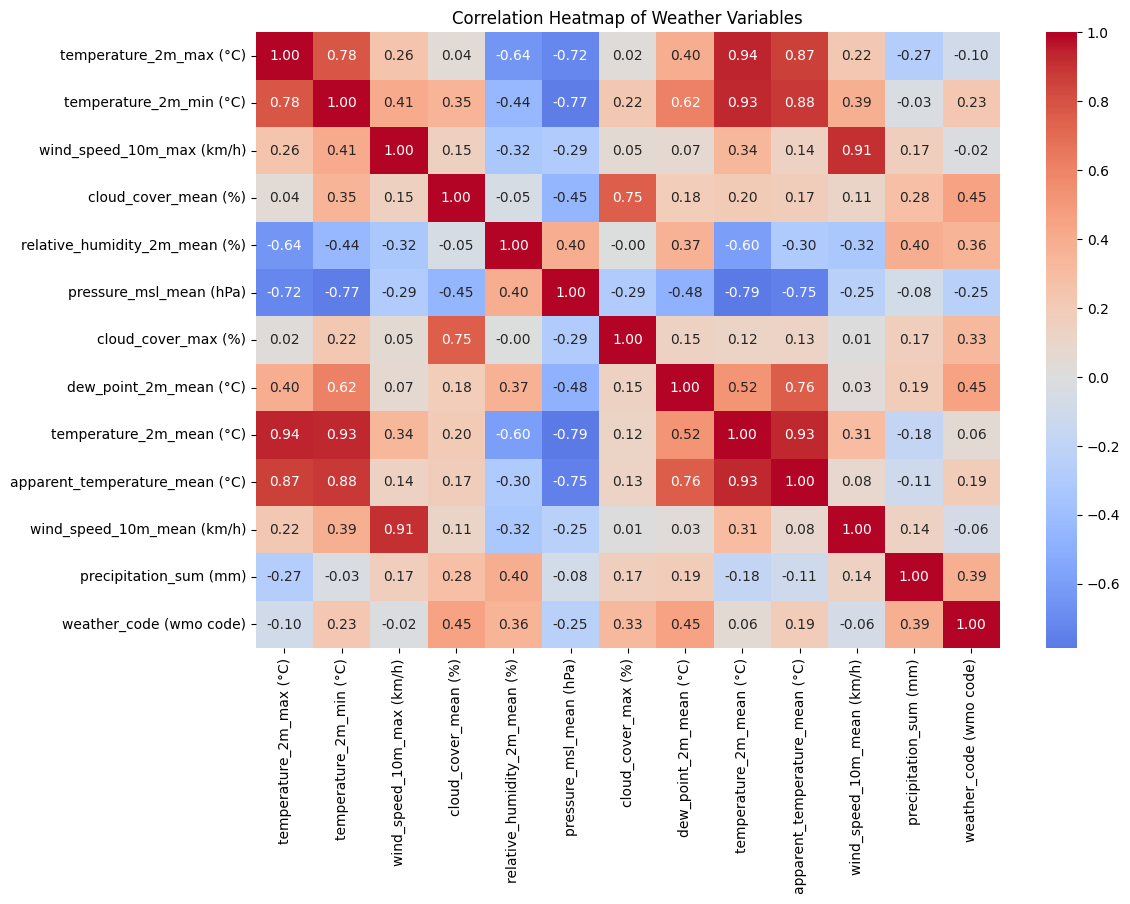

In [8]:
corr = weather[variables].corr()   # Pearson correlation by default
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap of Weather Variables")
plt.show()


In [9]:
weather = weather.drop(columns=[
    'temperature_2m_max (°C)',
    'temperature_2m_min (°C)',
    'apparent_temperature_mean (°C)',
    'wind_speed_10m_max (km/h)',
    'wind_speed_10m_mean (km/h)'
])

IndexError: index 4 is out of bounds for axis 0 with size 4

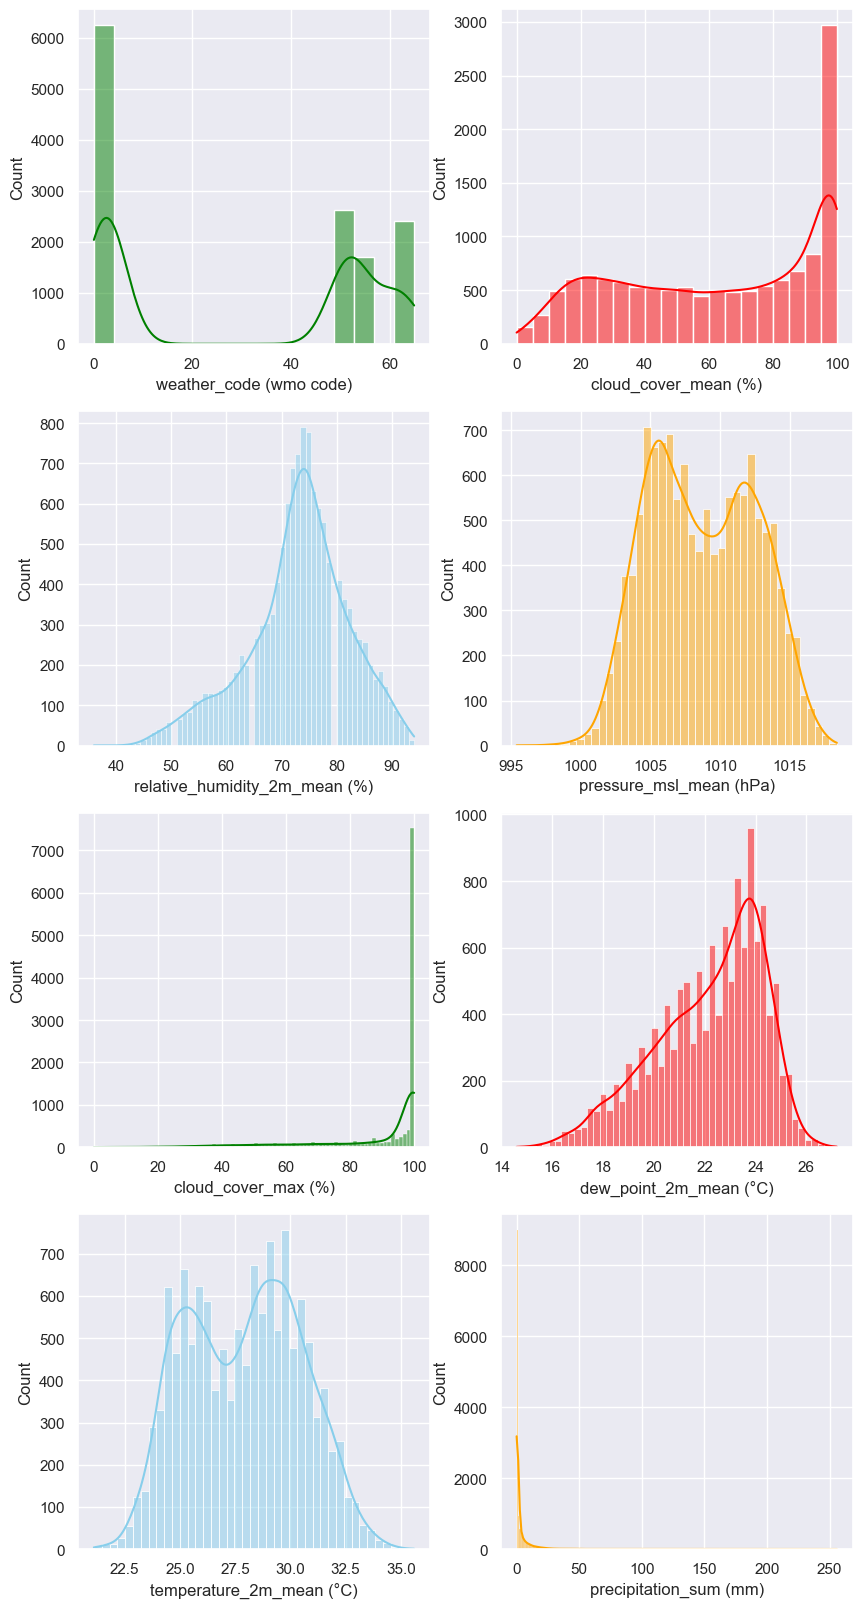

In [19]:
# set the plot style to darkgrid
sns.set(style="darkgrid")

fig, axs = plt.subplots(4, 2, figsize=(10, 20))
colors = ['green', 'red', 'skyblue', 'orange']

# loop through each column and its index in the dataframe
for i, column in enumerate(weather.columns):
    
    # create a histogram plot for the current column, with a kernel density estimate
    # set the current axis to the appropriate subplot in the grid
    # set the color of the histogram based on the index of the current column
    sns.histplot(data=weather, x=column, kde=True, 
             ax=axs[i//2, i%2], color=colors[i % len(colors)])


In [11]:
Q1 = weather.quantile(0.25)
Q3 = weather.quantile(0.75)
IQR = Q3 - Q1
weather , _ = weather.align((Q1 - 1.5 * IQR) | (weather > (Q3 + 1.5 * IQR)), axis=1, copy=False)

In [4]:
# Adding lag features
weather['target'] = weather['weather_code (wmo code)'].shift(-1)
weather = weather.iloc[:-1].copy()
weather['prev_code'] = weather['weather_code (wmo code)'].shift(1)
weather = weather.dropna(subset=['prev_code'])
weather['prev_code'] = weather['prev_code'].astype(int)

## Split

In [7]:
train = weather.loc[:"2017-05-31"].copy()
test  = weather.loc["2017-06-01":].copy()

X_train = train[predictors].copy()
y_train = train['target'].astype(int).copy()

X_test  = test[predictors].copy()
y_test  = test['target'].astype(int).copy()

## Model_1 Binary Predictor

In [9]:
y_train_s1 = (y_train == 3).astype(int)  
y_test_s1  = (y_test == 3).astype(int)

sw_s1 = compute_sample_weight(class_weight='balanced', y=y_train_s1)

model_stage1 = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    tree_method='hist'
)

model_stage1.fit(X_train, y_train_s1, sample_weight=sw_s1)
y_pred_s1 = model_stage1.predict(X_test)
print("Stage 1 (is code 3?) Classification Report:")
print(classification_report(y_test_s1, y_pred_s1, digits=3))
print("Stage1 accuracy:", accuracy_score(y_test_s1, y_pred_s1))

Stage 1 (is code 3?) Classification Report:
              precision    recall  f1-score   support

           0      0.864     0.743     0.799      2135
           1      0.509     0.695     0.588       817

    accuracy                          0.730      2952
   macro avg      0.687     0.719     0.693      2952
weighted avg      0.766     0.730     0.741      2952

Stage1 accuracy: 0.7300135501355014


## Model_2 Other Class Predictor

In [11]:
mask_train_s2 = (y_train != 3)
mask_test_s2  = (y_test != 3)

X_train_s2 = X_train[mask_train_s2].copy()
y_train_s2 = y_train[mask_train_s2].copy()

X_test_s2 = X_test[mask_test_s2].copy()
y_test_s2 = y_test[mask_test_s2].copy()

assert len(y_train_s2) > 0, "No training rows for Stage 2."

le_s2 = LabelEncoder()
y_train_s2_enc = le_s2.fit_transform(y_train_s2)
y_test_s2_enc  = le_s2.transform(y_test_s2)

sw_s2 = compute_sample_weight(class_weight='balanced', y=y_train_s2_enc)

model_stage2 = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    tree_method='hist'
)
model_stage2.fit(X_train_s2, y_train_s2_enc, sample_weight=sw_s2)
y_pred_s2_enc = model_stage2.predict(X_test_s2)
y_pred_s2 = le_s2.inverse_transform(y_pred_s2_enc)
print("\nStage 2 (which non-3 class?) Classification Report:")
print(classification_report(y_test_s2, y_pred_s2, digits=3))


Stage 2 (which non-3 class?) Classification Report:
              precision    recall  f1-score   support

           0      0.125     0.083     0.100        12
           1      0.160     0.342     0.218        76
           2      0.253     0.548     0.346       126
          51      0.570     0.303     0.396       778
          53      0.170     0.155     0.162       291
          55      0.057     0.101     0.073       109
          61      0.189     0.280     0.226       257
          63      0.430     0.437     0.433       403
          65      0.276     0.096     0.143        83

    accuracy                          0.302      2135
   macro avg      0.248     0.261     0.233      2135
weighted avg      0.370     0.302     0.313      2135



## Improve stage 2 aaccuracy